In [21]:
# General Imports
import pandas as pd
import numpy as np
from scipy.spatial.distance import cdist

from os.path import exists as path_exists
from os import makedirs

# Sklearn Imports
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn import metrics

import matplotlib.pyplot as plt
plt.style.use("ggplot")

In [22]:
DATA_DIR = "data/heart_failure_clinical_records_dataset.csv"
OUTPUT_DIR = "output/"

if not path_exists(OUTPUT_DIR):
    makedirs(OUTPUT_DIR)

In [23]:
df = pd.read_csv(DATA_DIR)
df.describe()

,age,anaemia,creatinine_phosphokinase,diabetes,ejection_fraction,high_blood_pressure,platelets,serum_creatinine,serum_sodium,sex,smoking,time,DEATH_EVENT
count,299.000000,299.000000,299.000000,299.000000,299.000000,299.000000,299.000000,299.00000,299.000000,299.000000,299.00000,299.000000,299.00000
mean,60.833893,0.431438,581.839465,0.418060,38.083612,0.351171,263358.029264,1.39388,136.625418,0.648829,0.32107,130.260870,0.32107
std,11.894809,0.496107,970.287881,0.494067,11.834841,0.478136,97804.236869,1.03451,4.412477,0.478136,0.46767,77.614208,0.46767
min,40.000000,0.000000,23.000000,0.000000,14.000000,0.000000,25100.000000,0.50000,113.000000,0.000000,0.00000,4.000000,0.00000
25%,51.000000,0.000000,116.500000,0.000000,30.000000,0.000000,212500.000000,0.90000,134.000000,0.000000,0.00000,73.000000,0.00000
50%,60.000000,0.000000,250.000000,0.000000,38.000000,0.000000,262000.000000,1.10000,137.000000,1.000000,0.00000,115.000000,0.00000
75%,70.000000,1.000000,582.000000,1.000000,45.000000,1.000000,303500.000000,1.40000,140.000000,1.000000,1.00000,203.000000,1.00000
max,95.000000,1.000000,7861.000000,1.000000,80.000000,1.000000,850000.000000,9.40000,148.000000,1.000000,1.00000,285.000000,1.00000


In [32]:
X_std = StandardScaler().fit_transform(df.drop("DEATH_EVENT", axis=1))
df_std = pd.DataFrame(X_std, columns=df.drop("DEATH_EVENT", axis=1).columns)
df_std.describe()

,age,anaemia,creatinine_phosphokinase,diabetes,ejection_fraction,high_blood_pressure,platelets,serum_creatinine,serum_sodium,sex,smoking,time
count,2.990000e+02,2.990000e+02,299.000000,2.990000e+02,2.990000e+02,299.000000,2.990000e+02,2.990000e+02,2.990000e+02,2.990000e+02,2.990000e+02,2.990000e+02
mean,5.703353e-16,1.009969e-16,0.000000,9.060014e-17,-3.267546e-17,0.000000,7.723291e-17,1.425838e-16,-8.673849e-16,-8.911489e-18,-1.188199e-17,-1.901118e-16
std,1.001676e+00,1.001676e+00,1.001676,1.001676e+00,1.001676e+00,1.001676,1.001676e+00,1.001676e+00,1.001676e+00,1.001676e+00,1.001676e+00,1.001676e+00
min,-1.754448e+00,-8.711048e-01,-0.576918,-8.475794e-01,-2.038387e+00,-0.735688,-2.440155e+00,-8.655094e-01,-5.363206e+00,-1.359272e+00,-6.876819e-01,-1.629502e+00
25%,-8.281242e-01,-8.711048e-01,-0.480393,-8.475794e-01,-6.841802e-01,-0.735688,-5.208700e-01,-4.782047e-01,-5.959961e-01,-1.359272e+00,-6.876819e-01,-7.389995e-01
50%,-7.022315e-02,-8.711048e-01,-0.342574,-8.475794e-01,-7.076750e-03,-0.735688,-1.390846e-02,-2.845524e-01,8.503384e-02,7.356882e-01,-6.876819e-01,-1.969543e-01
75%,7.718891e-01,1.147968e+00,0.000166,1.179830e+00,5.853888e-01,1.359272,4.111199e-01,5.926150e-03,7.660638e-01,7.356882e-01,1.454161e+00,9.387595e-01
max,2.877170e+00,1.147968e+00,7.514640,1.179830e+00,3.547716e+00,1.359272,6.008180e+00,7.752020e+00,2.582144e+00,7.356882e-01,1.454161e+00,1.997038e+00


## KMeans on Original Data (w/ standard scaling)

In [39]:
k_list = range(2, 30)

k_scores = np.zeros((len(k_list), 4))

for idx, n_clusters in enumerate(k_list):
    km = KMeans(n_clusters=n_clusters)
    km.fit(df_std)

    k_scores[idx][0] = n_clusters
    k_scores[idx][1] = km.inertia_
    k_scores[idx][2] = sum(
        np.min(
            cdist(df_std, km.cluster_centers_,'euclidean'), 
            axis=1
        )
    ) / df_std.shape[0]
    k_scores[idx][3] = metrics.silhouette_score(df_std, km.labels_, metric="euclidean")

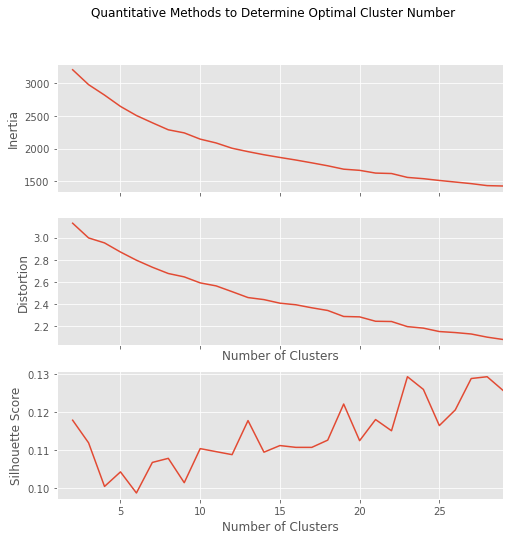

In [40]:
fig, ax = plt.subplots(3, sharex=True, figsize=(8, 8))

plt.suptitle("Quantitative Methods to Determine Optimal Cluster Number")

# Inertia Chart
ax[0].plot(k_scores[:, 0], k_scores[:, 1])
ax[0].set_ylabel("Inertia")
ax[0].set_xlim(1, max(k_list))
# ax[0].set_ylim(2000, 3500)

# Distortion Chart
ax[1].plot(k_scores[:, 0], k_scores[:, 2])
ax[1].set_ylabel("Distortion")
ax[1].set_xlabel("Number of Clusters")
# ax[1].set_ylim(2.5, 3.5)

# Silhouette Chart
ax[2].plot(k_scores[:, 0], k_scores[:, 3])
ax[2].set_ylabel("Silhouette Score")
ax[2].set_xlabel("Number of Clusters")

plt.show()

It is hard to tell from this noisy dataset, but it seems like k=2 is most optimal choice in **this representation**.

In [41]:
kmeans_scale = KMeans(n_clusters=2, n_init=100, max_iter=500).fit(df_std)
scale_silhoutte_score = metrics.silhouette_score(df_std, kmeans_scale.labels_, metric="euclidean")
print(f"KMeans Scaled Silhouette Score: {scale_silhoutte_score}")

labels_scale = kmeans_scale.labels_

KMeans Scaled Silhouette Score: 0.1178512561512019


Let's try to compress the information down into a smaller dimensionality, so we can visualize what just happned.

In [42]:
pca = PCA(n_components=3)
principal_components = pca.fit_transform(df_std)
pca_df = pd.DataFrame(principal_components)

pca_df.head()

,0,1,2
0,0.877055,2.287104,1.033230
1,1.863753,-1.552894,0.719821
2,2.526429,1.369821,1.285596
3,0.579566,1.143232,0.631174
4,-0.960485,2.639384,4.430958


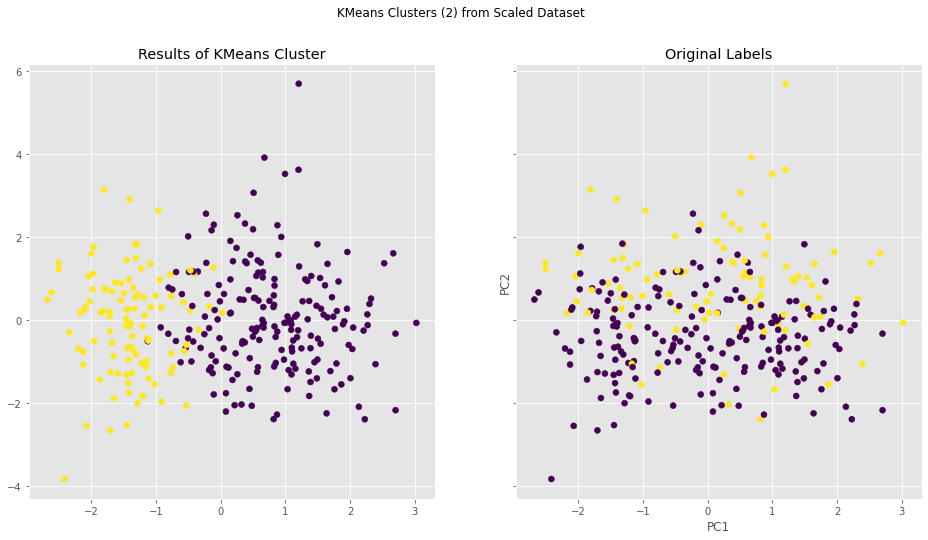

In [43]:
fig, ax = plt.subplots(1, 2, sharex=True, sharey=True, figsize=(16, 8))

plt.suptitle("KMeans Clusters (2) from Scaled Dataset")

ax[0].set_title("Results of KMeans Cluster")
ax[0].scatter(pca_df[0], pca_df[1], c=labels_scale)

ax[1].set_title("Original Labels")
ax[1].scatter(pca_df[0], pca_df[1], c=df["DEATH_EVENT"])

plt.xlabel("PC1")
plt.ylabel("PC2")
plt.show()

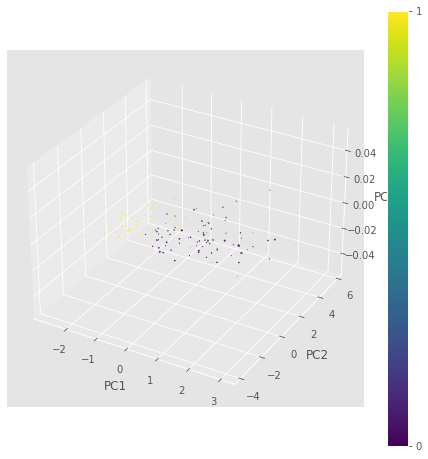

In [44]:
fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111, projection='3d')

plt.scatter(pca_df[0], pca_df[1], pca_df[2], c=labels_scale)
plt.colorbar(ticks=np.arange(labels_scale.min(), labels_scale.max()+1))

ax.set_xlabel("PC1")
ax.set_ylabel("PC2")
ax.set_zlabel("PC3")
plt.show()

## Feature Reduction with PCA

In the previous visualization, we arbitrarily set the number of components. Let us now determine the minimum number of components to describe at least 70% of the variance.

We will first inspect the contribution of each feature towards the variance if we allow n_components to scale to the number of features in the original dataset (13).

In [49]:
pca = PCA(n_components=len(df_std.columns))
principal_components = pca.fit_transform(df_std)
pca_df = pd.DataFrame(principal_components)

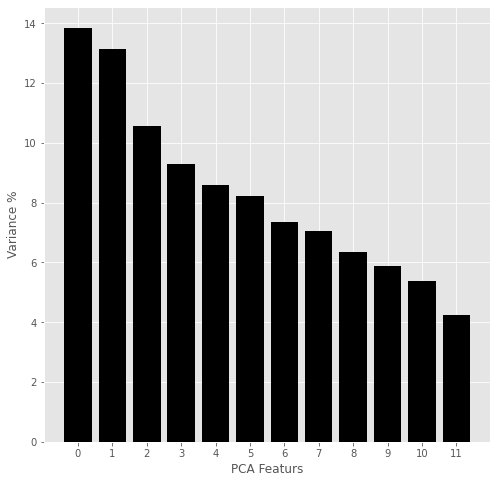

In [50]:
fig = plt.figure(figsize=(8, 8))

features = range(pca.n_components_)
plt.bar(features, pca.explained_variance_ratio_*100.0, color="k")
plt.xlabel("PCA Featurs")
plt.ylabel("Variance %")
plt.xticks(features)
plt.show()

<Figure size 576x576 with 0 Axes>

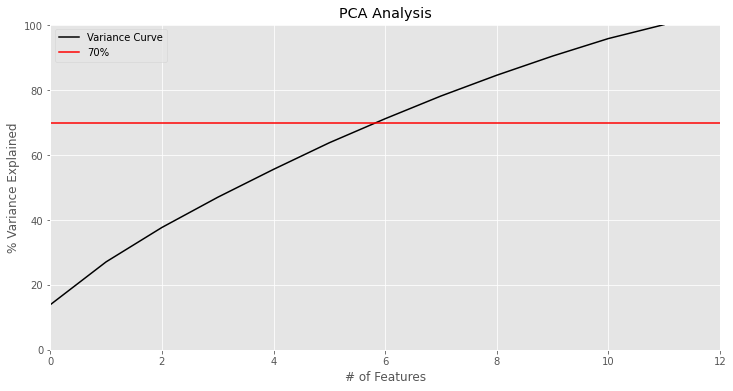

In [52]:
var = np.cumsum(np.round(pca.explained_variance_ratio_, 3)*100)

fig = plt.figure(figsize=(8, 8))

plt.figure(figsize=(12,6))
plt.title('PCA Analysis')

plt.plot(var, label="Variance Curve", color="k")
plt.axhline(y=70, label="70%", color="r")
# plt.axvline(x=np.where(np.abs(var-70) <= 0.01)[0], color="r")

plt.ylabel('% Variance Explained')
plt.xlabel('# of Features')
plt.xlim(0, 12)
plt.ylim(0,100.5)
plt.legend()
plt.show()

What this analysis tells us is the variance can be _mostly_ represented by 6 dimensions instead of 13, which is a signficant reduction in dimensionality.

In [54]:
pca = PCA(n_components=6)
pca_scale = pca.fit_transform(df_std)
pca_df_scale = pd.DataFrame(pca_scale)

print(f"Explained Variance RatioS: {pca.explained_variance_ratio_}")

Explained Variance RatioS: [0.13858049 0.13159129 0.10567855 0.09299485 0.0858236  0.08240632]


## Applying KMeans to PCA Principal Components

Let us now repeat the process, except let's use our PCA represented matrix with 6 dimensions.

In [55]:
k_list = range(2, 20)

k_scores = np.zeros((len(k_list), 4))

for idx, n_clusters in enumerate(k_list):
    km = KMeans(n_clusters=n_clusters)
    km.fit(pca_df_scale)

    k_scores[idx][0] = n_clusters
    k_scores[idx][1] = km.inertia_
    k_scores[idx][2] = sum(
        np.min(
            cdist(pca_df_scale, km.cluster_centers_,'euclidean'), 
            axis=1
        )
    ) / pca_df_scale.shape[0]
    k_scores[idx][3] = metrics.silhouette_score(pca_df_scale, km.labels_, metric="euclidean")

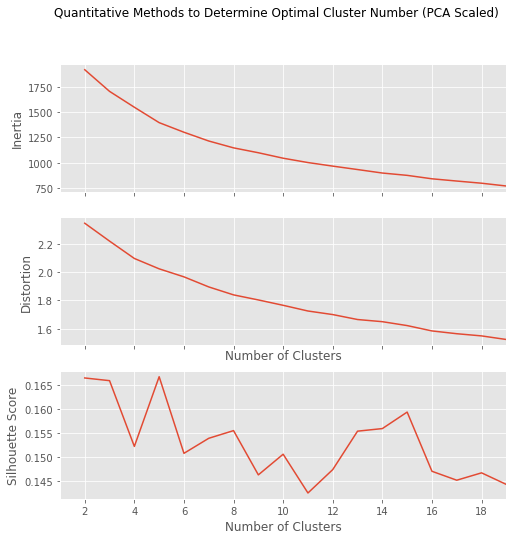

In [56]:
fig, ax = plt.subplots(3, sharex=True, figsize=(8, 8))

plt.suptitle("Quantitative Methods to Determine Optimal Cluster Number (PCA Scaled)")

# Inertia Chart
ax[0].plot(k_scores[:, 0], k_scores[:, 1])
ax[0].set_ylabel("Inertia")
ax[0].set_xlim(1, max(k_list))

# Distortion Chart
ax[1].plot(k_scores[:, 0], k_scores[:, 2])
ax[1].set_ylabel("Distortion")
ax[1].set_xlabel("Number of Clusters")

# Silhouette Chart
ax[2].plot(k_scores[:, 0], k_scores[:, 3])
ax[2].set_ylabel("Silhouette Score")
ax[2].set_xlabel("Number of Clusters")

plt.show()

We see that k=2 is still the preferred cluster number. Additionally, we immediately notice a slightly higher silhouette score.

In [57]:
kmeans_pca_scale = KMeans(n_clusters=2, n_init=100, max_iter=500).fit(pca_df_scale)
pca_scale_silhoutte_score = metrics.silhouette_score(pca_df_scale, kmeans_pca_scale.labels_, metric="euclidean")
print(f"KMeans Scaled Silhouette Score: {pca_scale_silhoutte_score}")

labels_pca_scale = kmeans_pca_scale.labels_

KMeans Scaled Silhouette Score: 0.16742502008696922


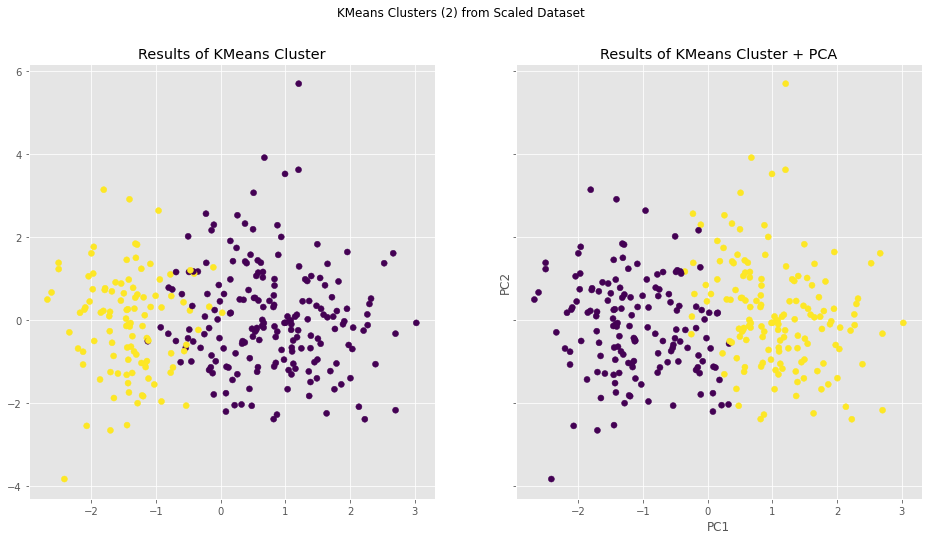

In [58]:
fig, ax = plt.subplots(1, 2, sharex=True, sharey=True, figsize=(16, 8))

plt.suptitle("KMeans Clusters (2) from Scaled Dataset")


ax[0].set_title("Results of KMeans Cluster")
ax[0].scatter(pca_df[0], pca_df[1], c=labels_scale)

ax[1].set_title("Results of KMeans Cluster + PCA")
ax[1].scatter(pca_df_scale[0], pca_df_scale[1], c=labels_pca_scale)


# ax[0].colorbar(ticks=np.arange(labels_scale.min(), labels_scale.max()+1))

plt.xlabel("PC1")
plt.ylabel("PC2")
plt.show()